In [1]:
import librosa
import numpy as np
import os 
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
#JUST TEST THAT PATH WORKS CORRECTLY

In [3]:
FILE_PATH = './vcc2018_training/VCC2SF1/10040.wav'

In [4]:
ipd.Audio(FILE_PATH)

In [5]:
#TESTS WITH A SINGLE FILE

In [6]:
audio_file, sr = librosa.load(FILE_PATH)

In [7]:
sr

22050

In [8]:
audio_file.shape


(150978,)

In [9]:
HOP_SIZE = 1024
FRAME_SIZE = 2048

In [10]:
spectrogram_in_complex = librosa.stft(audio_file, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [11]:
spectrogram_in_complex.shape


(1025, 148)

In [12]:
spectrogram = np.abs(spectrogram_in_complex)


In [13]:
spectrogram.shape

(1025, 148)

In [14]:
#LET'S SEE HOW IT LOOKS ON THE PLOT

In [15]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

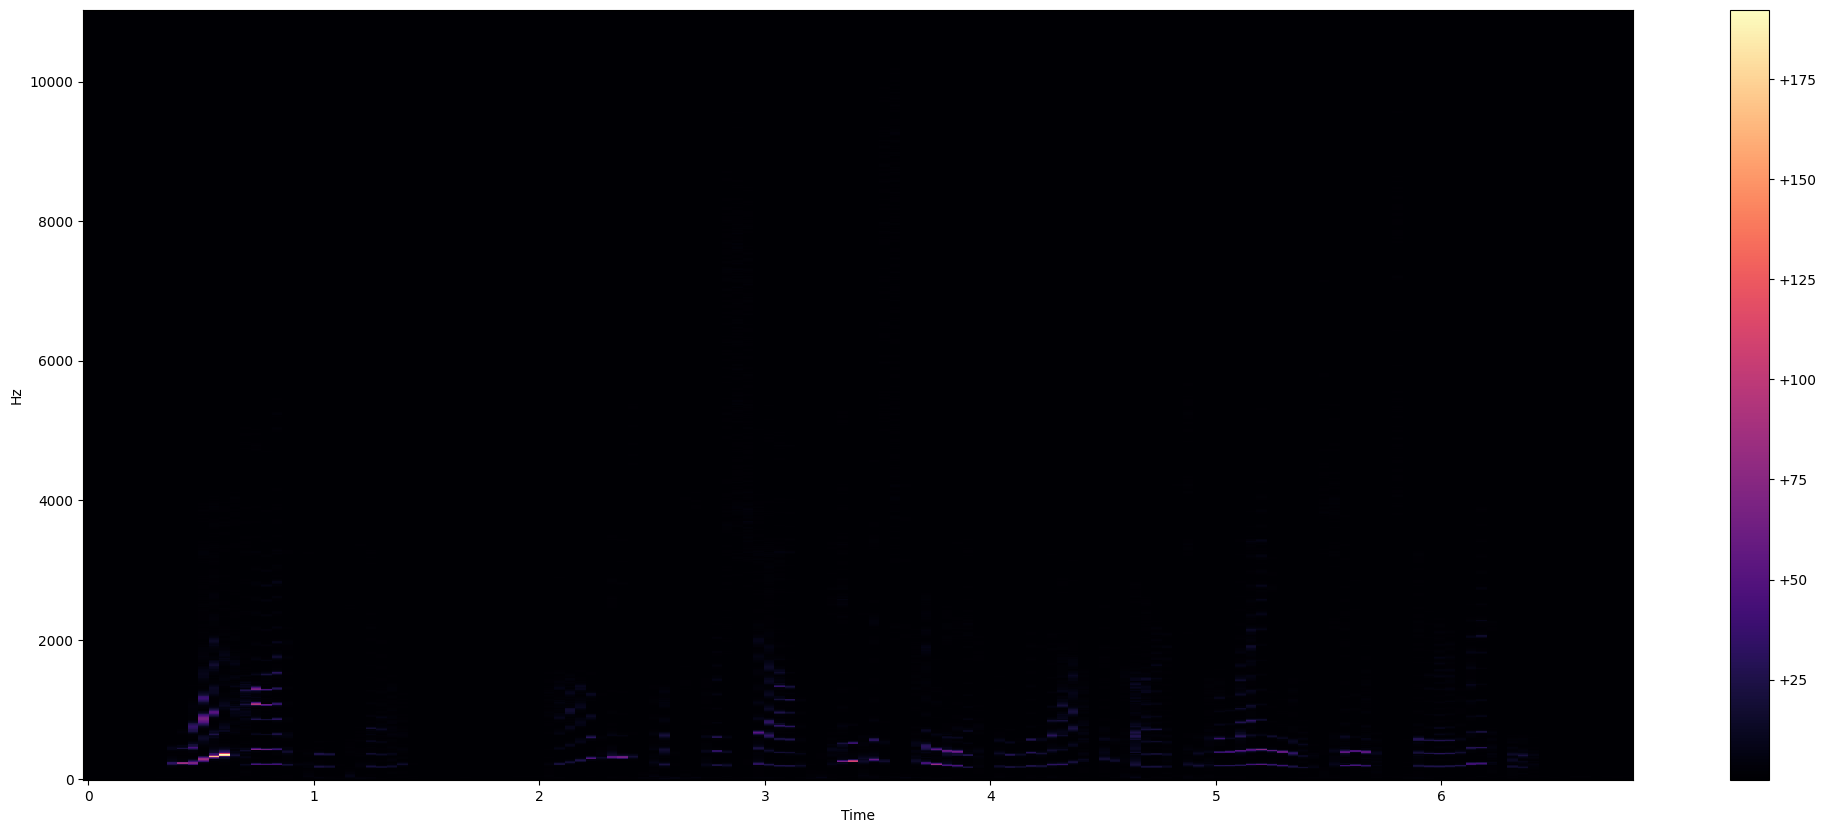

In [16]:
plot_spectrogram(spectrogram, sr, HOP_SIZE)

In [17]:
#NOT GOOD. BECAUSE IT'S BETTER TO REPRESENT THE db INSTEAD THE MAGNOTUDE

In [18]:
log_spectogram = librosa.amplitude_to_db(spectrogram)

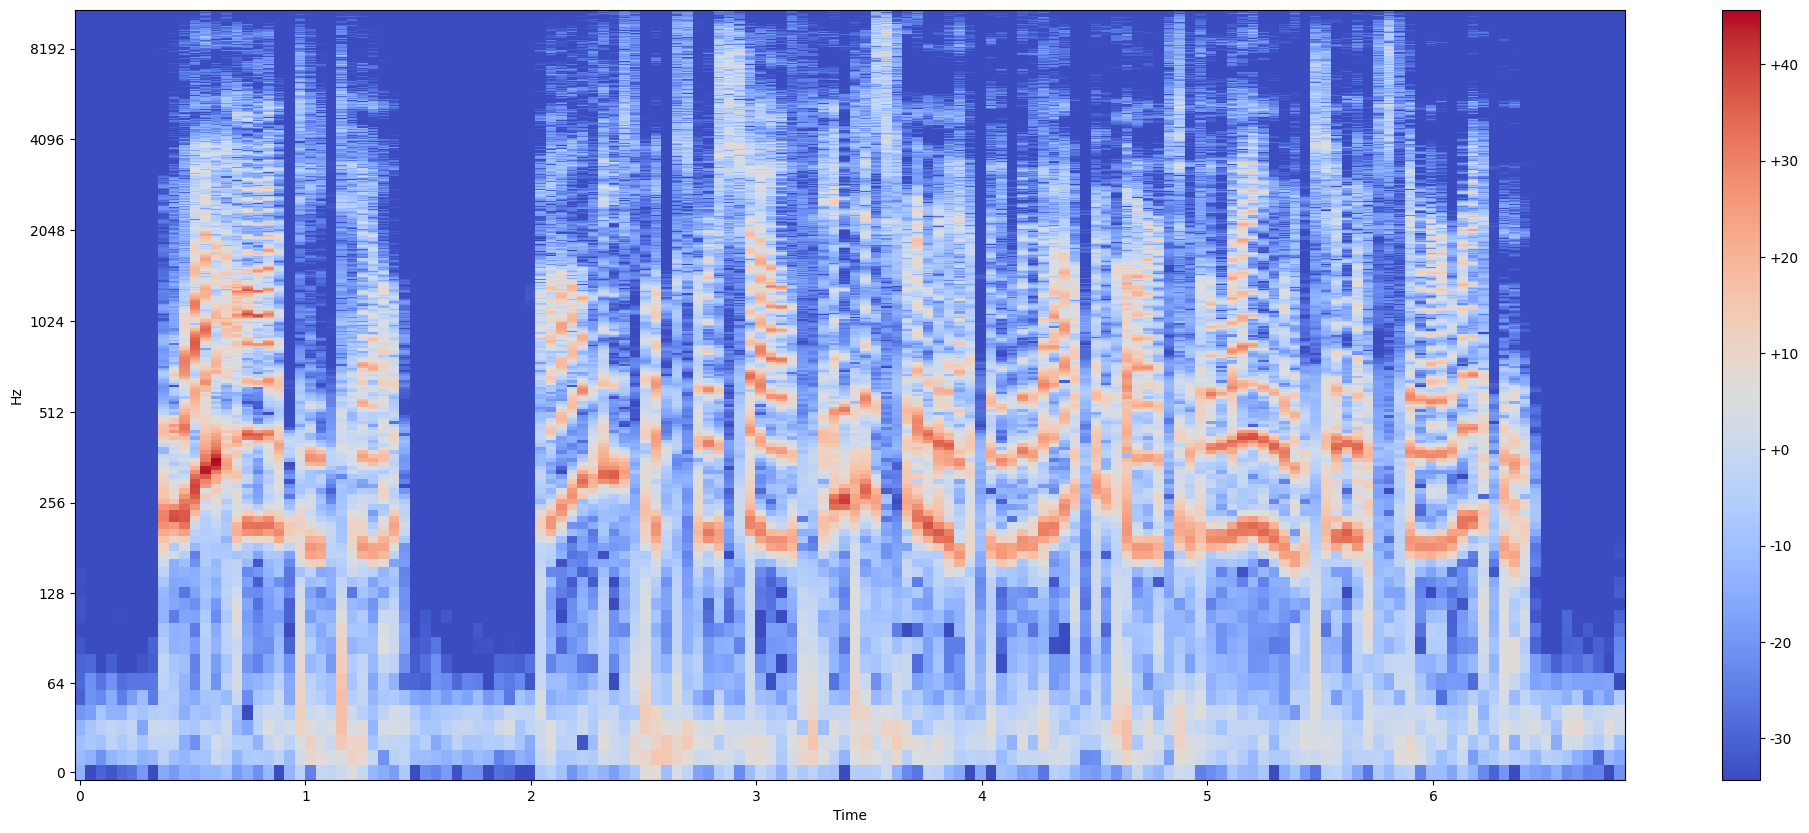

In [19]:
plot_spectrogram(log_spectogram, sr, HOP_SIZE, y_axis='log')

In [20]:
#MUCH MORE BETTER. NOW LET'S IMPLEMENT ISTFT.

In [21]:
new_spec = librosa.db_to_amplitude(log_spectogram)
new_sound = librosa.istft(new_spec, hop_length=HOP_SIZE)

In [22]:
new_sound.shape

(150528,)

In [23]:
ipd.Audio(new_sound, rate=sr)

In [24]:
#NOT CONVINCING AT ALL. LET'S TRY TO GET THE AUDIO FROM THE ORIGINAL SPECTROGRAM.

In [25]:
type(spectrogram_in_complex[0][0])

numpy.complex64

In [26]:
spec_to_sound = librosa.istft(spectrogram_in_complex, hop_length=HOP_SIZE)
spec_to_sound.shape

(150528,)

In [27]:
ipd.Audio(spec_to_sound, rate=sr)

In [28]:
#NOW IT IS VERY NICE AND CLOSE TO THE ORIGINAL. SO IT'S BETTER NOT TO CONVERT TO AMLITUDES.

In [29]:
#LET'S TRY TO DEVIDE COMPLEX TO TWO CHANNELS: REAL AND IMAGINARY PARTS
spec_reals = spectrogram_in_complex.real
spec_imag = spectrogram_in_complex.imag
spec_reals = spec_reals[np.newaxis, ...]
spec_imag = spec_imag[np.newaxis, ...]
data = np.concatenate((spec_reals, spec_imag), axis=0)
print(spec_reals)
print(data[0])
print(spec_imag)
print(data[1])


[[[-2.00738683e-01 -5.18373307e-03 -3.23315822e-02 ...  6.48043901e-02
    1.23571530e-02 -9.29114521e-02]
  [ 2.66698301e-01  7.48722553e-02 -5.63613437e-02 ...  3.47130634e-02
    1.12175055e-01  1.51972622e-01]
  [-1.72148600e-01 -3.31395119e-01  3.04735690e-01 ... -7.92715177e-02
   -6.09804094e-01 -3.07886265e-02]
  ...
  [-1.79735303e-04  2.03645555e-04  3.46675079e-04 ...  5.04510885e-04
   -1.65723948e-04  7.23183446e-04]
  [ 3.79401230e-04  3.35341028e-04 -5.36921259e-04 ... -5.37278072e-04
    5.06003562e-05 -3.71638947e-04]
  [-5.45600022e-04 -8.11214326e-04  6.88008149e-04 ...  3.75173899e-04
    1.38676245e-04  1.71207619e-04]]]
[[-2.00738683e-01 -5.18373307e-03 -3.23315822e-02 ...  6.48043901e-02
   1.23571530e-02 -9.29114521e-02]
 [ 2.66698301e-01  7.48722553e-02 -5.63613437e-02 ...  3.47130634e-02
   1.12175055e-01  1.51972622e-01]
 [-1.72148600e-01 -3.31395119e-01  3.04735690e-01 ... -7.92715177e-02
  -6.09804094e-01 -3.07886265e-02]
 ...
 [-1.79735303e-04  2.03645555e

In [30]:
np.allclose(spectrogram_in_complex, data[0] + 1j * data[1])

True

In [31]:
chan_to_sound = librosa.istft(data[0] + 1j * data[1], hop_length=HOP_SIZE)
spec_to_sound.shape

(150528,)

In [32]:
ipd.Audio(chan_to_sound, rate=sr)

In [33]:
#NOW LET'S IMPLEMENT USEFUL FUNCTIONS TO PREPROCESSING THE AUDIO

In [34]:
def LoadFile(file_path, duration):
    #LOADS THE FILE 
    audio, sr = librosa.load(file_path, duration=duration)
    
    return audio
            
            

In [35]:
def GetSpec(audio, hop_size, frame_size):
    spec = librosa.stft(audio, hop_length=hop_size, n_fft=frame_size)
    spec_reals = spec.real
    spec_imag = spec.imag
    spec_reals = spec_reals[np.newaxis, ...]
    spec_imag = spec_imag[np.newaxis, ...]
    data = np.concatenate((spec_reals, spec_imag), axis=0)
    
    return data

In [36]:
def NormaliseData(data, db_data):

    sig = np.std(db_data)
    
    print(sig)
    norm_data = data / sig
    print(norm_data.shape)
    
    return norm_data, sig

In [37]:
def ApplyRightPadding(audio_array, size):
    padding = np.array([0 for _ in range(size)])
    audio_array = np.concatenate((audio_array, padding), axis=0)
    
    return audio_array

In [38]:
def DenormalizeData(spec, sig):
    original_spec = spec * sig 
    
    return original_spec
    

In [39]:
def FreqToDB(spec):
    real_part = spec[0]
    imag_part = spec[1]
    db_real_spec = librosa.amplitude_to_db(real_part)
    db_imag_spec = librosa.amplitude_to_db(imag_part)
    
    return db_real_spec, db_imag_spec
    

In [40]:
def ISTFT(spec, hop_size):
    audio = librosa.istft(spec, hop_length=hop_size)
    
    return audio

In [41]:
def SaveData(data, save_dir, file_name):
    np.save(os.path.join(save_dir, file_name), data)


In [42]:
#PUT EVERYTHING TOGETHER

In [43]:
DURATION = 2
FRAME_SIZE = 512
HOP_SIZE = 256
SAMPLE_RATE = 22050
PATH_TO_DIR = './vcc2018_training/VCC2SF1'
SAVE_DIR = './save_dir'

In [44]:
def PreprocessAudioData(path_to_dir, duration, sr, frame_size, hop_size, save_dir):
    data = []
    data_db = []
    
    for root, _ , files in os.walk(path_to_dir):
        for file in files:
            path = os.path.join(root, file)
            audio = LoadFile(path, duration)
            
            if audio.shape[0] < duration * sr:
                size = duration * sr - audio.shape[0]
                audio = ApplyRightPadding(audio, size)
            
            data_sample = GetSpec(audio, HOP_SIZE, FRAME_SIZE)
            data.append(data_sample)
            real_db, imag_db = FreqToDB(data_sample)
            real_db = real_db[np.newaxis, ...]
            imag_db = imag_db[np.newaxis, ...]
            data_sample_db = np.concatenate((real_db, imag_db), axis=0)
            data_db.append(data_sample_db)
            
    data = np.array(data)
    data_db = np.array(data_db)
    data, sigma = NormaliseData(data, data_db)
    #SaveData(data, save_dir, 'data.npy')
    print(data.shape)
    
    return data, data_db, sigma

In [45]:
DATA, DATA_DB, SIGMA = PreprocessAudioData(PATH_TO_DIR, DURATION, SAMPLE_RATE, FRAME_SIZE, HOP_SIZE, SAVE_DIR)

15.78064125755268
(81, 2, 257, 173)
(81, 2, 257, 173)


In [61]:
SaveData(DATA, SAVE_DIR, 'data.npy')

<class 'numpy.ndarray'>


In [62]:
data = np.load('./save_dir/data.npy')
data.shape

(81, 2, 257, 173)

In [51]:
#OK. SEEMS LIKE IT WORKS AND WE PREPARED DATA. NOW LET'S SEE HOW WE CAN RECONSTRUCT THE AUDIO FROM THE SPECTRUM.

In [52]:
def ReconstructSignal(spec, hop_size, sig):
    original_spec = DenormalizeData(spec, sig)
    print(original_spec.shape)
    original_spec = original_spec[0] + 1j * original_spec[1]
    print(original_spec.shape)
    audio = ISTFT(original_spec, hop_size=hop_size)
    return audio

In [53]:
reconstructed_audio = ReconstructSignal(DATA, HOP_SIZE, SIGMA)
reconstructed_audio.shape


(81, 2, 257, 173)
(2, 257, 173)


(2, 44032)

In [54]:
original_audio, _ = librosa.load('./vcc2018_training/VCC2SF1/10001.wav', duration=DURATION)
original_audio.shape

(44100,)

In [55]:
#ORIGINAL AUDIO
ipd.Audio(original_audio, rate=SAMPLE_RATE)

In [56]:
#RECOSTRUCTED AUDIO
ipd.Audio(reconstructed_audio, rate=SAMPLE_RATE)

In [57]:
a = np.array([1, 2])
type(a)

numpy.ndarray

In [58]:
print(DATA_DB[0][0])
print(DATA_DB[0][1])

[[-36.60141754 -12.50548744 -22.77441025 ...  -8.2407198  -10.9282198
  -17.07210922]
 [-34.05295944 -16.66198158 -23.94436264 ... -10.77193069 -15.26346016
  -31.34197044]
 [-43.41003418 -31.48973465 -30.96097946 ... -23.41377449 -28.00507736
  -15.96541405]
 ...
 [-59.31656647 -59.31656647 -59.31656647 ... -54.29273605 -37.30883026
  -45.25056839]
 [-59.31656647 -59.31656647 -59.31656647 ... -40.55469894 -49.20879745
  -51.40077209]
 [-59.31656647 -59.31656647 -59.31656647 ... -41.29377365 -35.98428345
  -55.32798767]]
[[-60.03622055 -60.03622055 -60.03622055 ... -60.03622055 -60.03622055
  -60.03622055]
 [-43.26209641 -20.81313896 -16.05125046 ... -25.43096161 -12.74356461
  -13.77173519]
 [-33.65502167 -27.38465881 -28.28220558 ... -24.52935028 -28.66727829
  -21.0698719 ]
 ...
 [-60.03622055 -60.03622055 -60.03622055 ... -57.70088196 -51.60510635
  -42.38005829]
 [-60.03622055 -60.03622055 -60.03622055 ... -36.38840866 -43.02927017
  -45.26446533]
 [-60.03622055 -60.03622055 -60.0

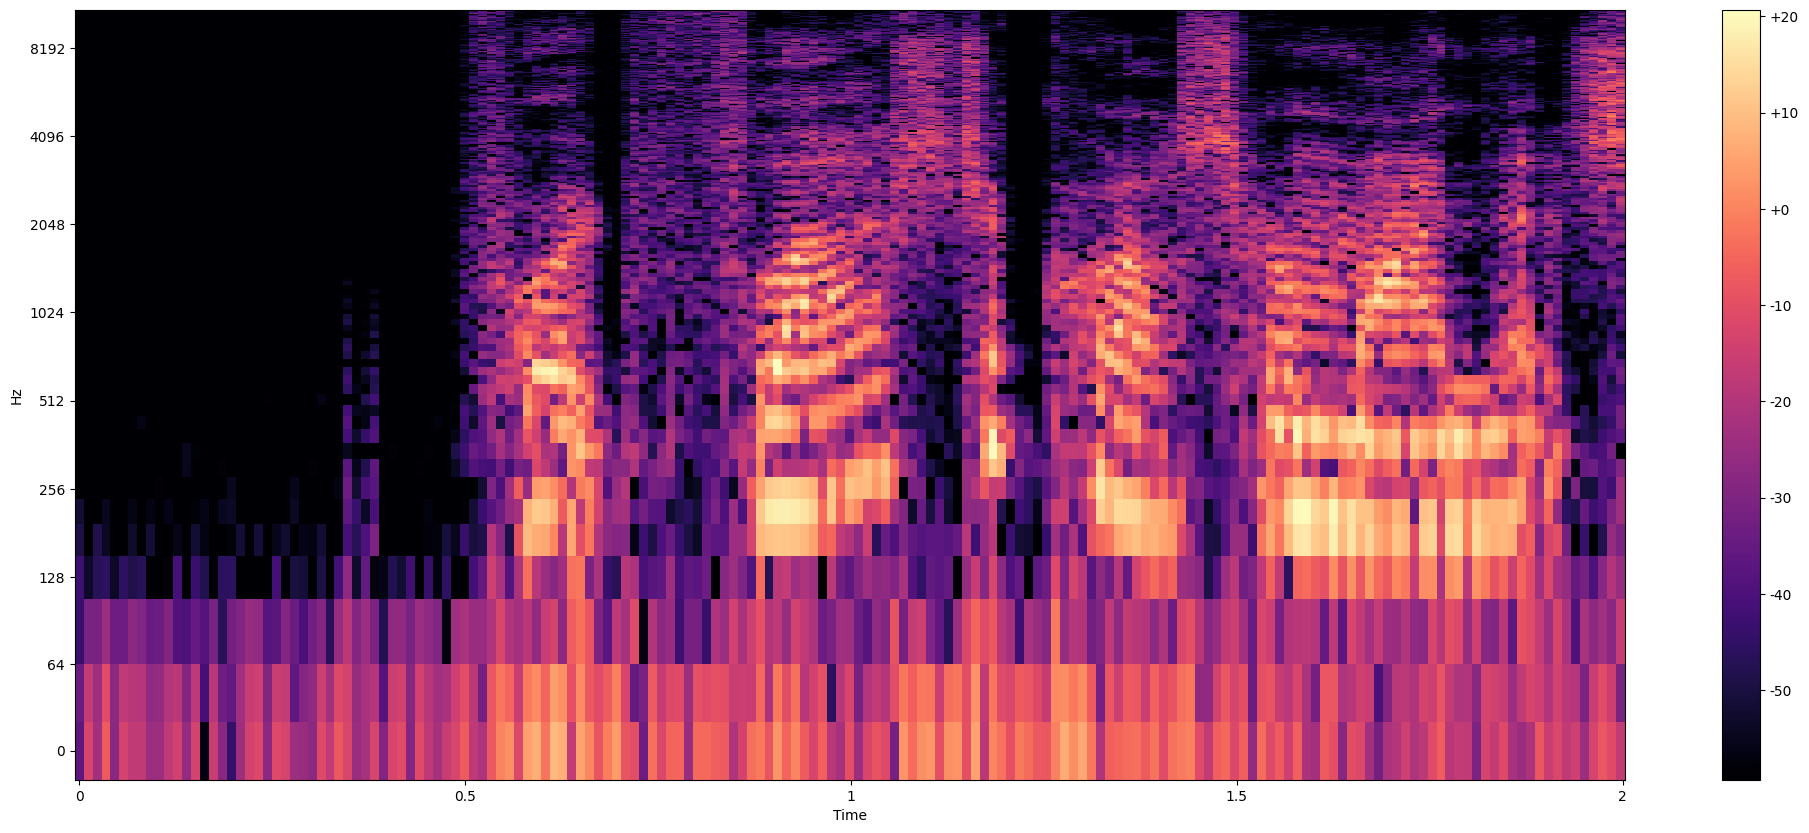

In [59]:
#REAL PART SPECTROGRAM
plot_spectrogram(DATA_DB[0][0], SAMPLE_RATE, HOP_SIZE, y_axis='log')

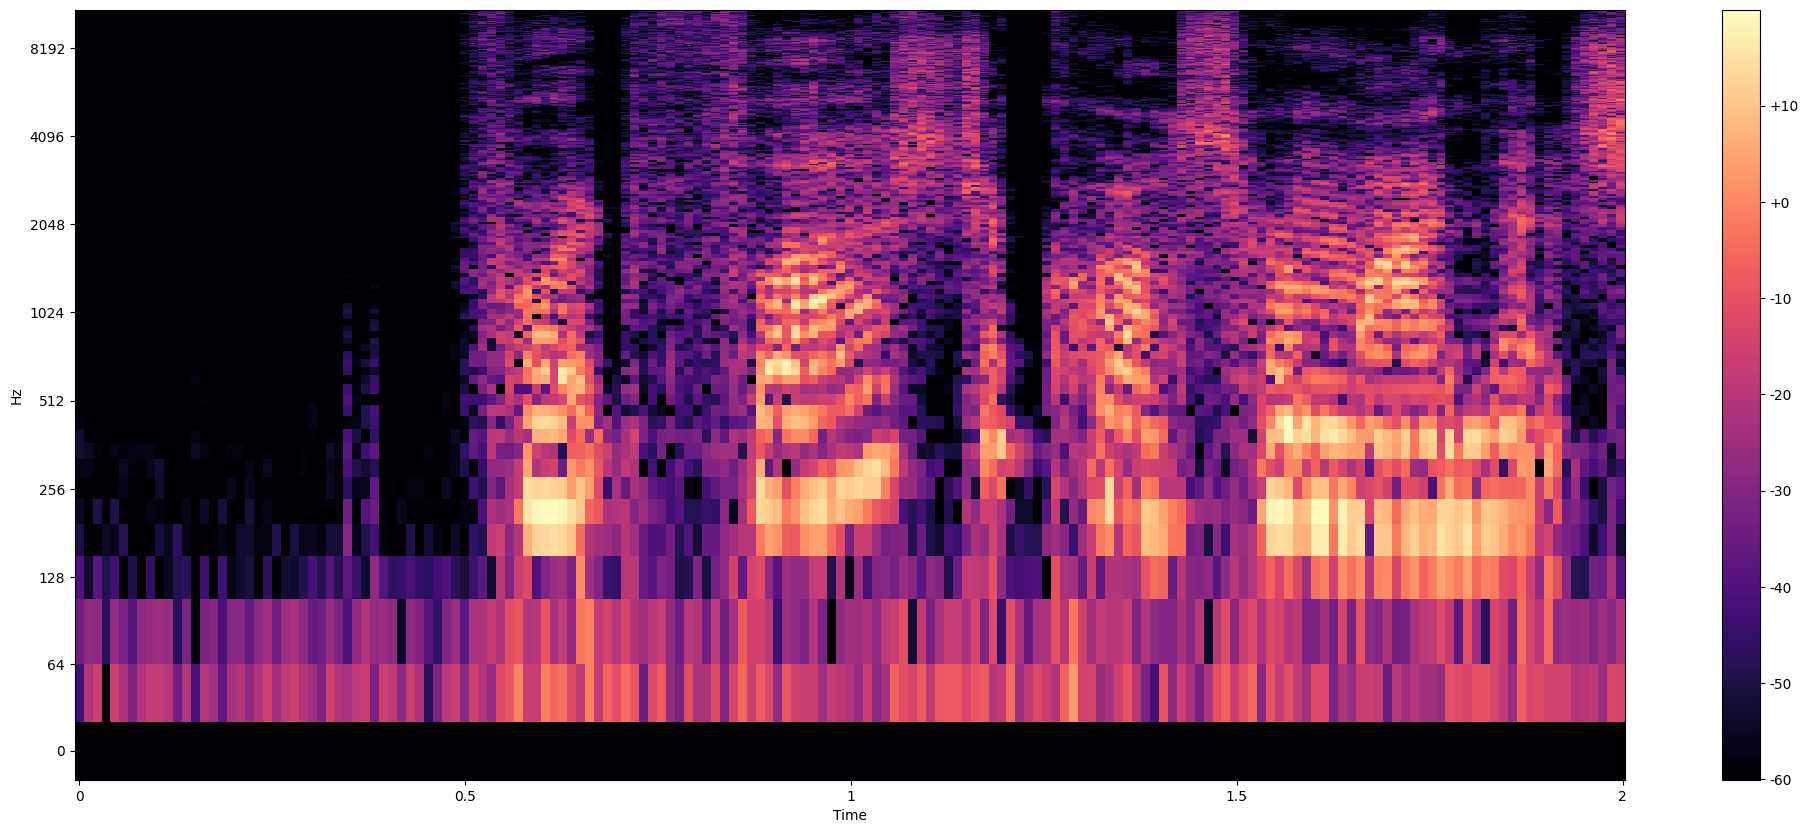

In [60]:
#IMAGINARY PART SPECTROGRAM
plot_spectrogram(DATA_DB[0][1], SAMPLE_RATE, HOP_SIZE, y_axis='log')